In [1]:
import cv2
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import os
import copy
import time
import importlib
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchsummary import summary

import model
importlib.reload(model)
from model import AutoencoderModel, AutoencoderModel_BIG
from utils.model_summary import model_summary

import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda')

In [2]:
train_data = "data\RICE_DATASET\RICE1"
train_list = r'data\RICE_DATASET\RICE1\train_list.txt'
test_list = r'data\RICE_DATASET\RICE1\test_list.txt'
image_dir = "data\RICE_DATASET\RICE1\cloudy_image"

len(os.listdir(image_dir))

500

In [3]:
class TrainDataset(Dataset):
    def __init__(self, train_list, img_dir, lab_dir, transform=None):
        super().__init__()

        self.img_dir = img_dir
        self.lab_dir = lab_dir
        self.imlist = np.loadtxt(train_list, str)
        self.imlist = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.imlist)
 
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imlist[idx])
        image = cv2.imread(img_path, 1).astype(np.float32)/255
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (128, 128))

        label_path = os.path.join(self.lab_dir, self.imlist[idx])
        label = cv2.imread(label_path, 1).astype(np.float32)/255
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # label = cv2.resize(label, (128, 128))

        if self.transform:
            image, label = self.transform(image), self.transform(label)
        
        return image, label


In [4]:
transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(512),
                        transforms.CenterCrop(512),
                        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                        ])

train_dataset =  TrainDataset(train_list, "data\RICE_DATASET\RICE1\cloudy_image", "data\RICE_DATASET\RICE1\ground_truth", transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size = 2, shuffle = True)

c:\Users\DELL\anaconda3\envs\dlcuda\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


250


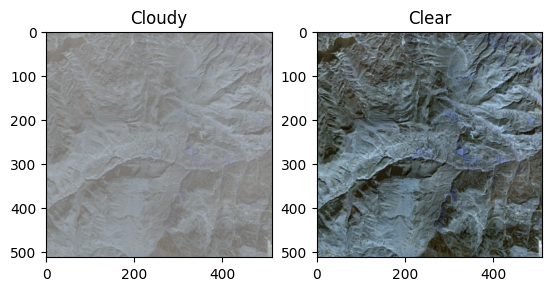

In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(len(iter(train_dataloader)))

fig, axs = plt.subplots(nrows = 1, ncols = 2)

axs[0].imshow(train_features[0].permute(1,2,0))
axs[0].set_title("Cloudy")
axs[1].imshow(train_labels[0].permute(1,2,0))
axs[1].set_title("Clear")

plt.show()

In [6]:
# import importlib
# import model
# importlib.reload(model)
# from model import AutoencoderModel

# model = AutoencoderModel()
# model.to(device)

# # train_features = train_features.to(device)

# # y = model(train_features)

# print(summary(model, (3, 512, 512), batch_size = 4))
# train_features.shape, y.shape

In [7]:
# plt.imshow(y[0][0].cpu().detach().numpy())
# plt.show()

In [8]:
# with torch.no_grad():
#     for param in model.parameters():
#         torch.nn.init.zeros_(param)

In [ ]:
class PSNR:
    def __init__(self):
        self.name = PSNR

    @staticmethod
    def __call__(img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        return 20 * torch.log10(1/torch.sqrt(mse))




In [9]:
import torch.optim as optim
from torch.optim import lr_scheduler

model = AutoencoderModel()
model = model.to(device)
lossf = nn.MSELoss()
epochs = 50
lr = 0.0003
betas = (0.9, 0.999)
momentum = 0.9
weight_decay = 0.0001

params = [p for p in model.parameters() if p.requires_grad]

optim = optim.Adam(params, lr = lr, betas = betas, weight_decay = weight_decay)
# lr_scheduler = lr_scheduler.StepLR(optim, step_size=7, gamma=0.1)

def train(model, lossf, optim, epochs, save_model = None):
    best_model_wts = copy.deepcopy(model.state_dict())
    LOSS = []
    min_loss = 1000

    for epoch in range(0, epochs):
        # print("Epoch {}/{}".format(epoch, epochs))

        epoch_start_time = time.time()
        
        epoch_LOSS = 0.0

        for phase in ['train', 'val']:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            for i, data in enumerate(train_dataloader):

                optim.zero_grad()
                image, label = data
                image, label = image.to(device), label.to(device)

                with torch.set_grad_enabled(phase == 'train'):    
                    out = model(image)
                    loss = lossf(out, label)

                    if phase == "train":
                        loss.backward()
                        optim.step()
                        # if i % 5 == 0:
                        #     print(loss, loss.item())
                        LOSS.append(loss.item())

                # if i % 10 == 0:
                #     print("Epoch: {} | Iterations: {}".format(epoch, i))
        # if phase == "train":
        #     schedular.step()

        epoch_LOSS = sum(LOSS) / len(LOSS)

        if phase=='val' and epoch_LOSS < min_loss:
            min_loss = epoch_LOSS
            best_model_wts = copy.deepcopy(model.state_dict())

        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        epoch_time = round(epoch_time, 1)

        print("Epoch: {} / {} | Time: {} secs | Loss: {} ".format(epoch, epochs, epoch_time, sum(LOSS)/len(LOSS)))
        # print()
        LOSS = []
    model.load_state_dict(best_model_wts)
    if save_model:
        torch.save(model, save_model)
    return model


In [10]:
model = train(model, lossf, optim, epochs = 20)

Epoch: 0 / 20 | Time: 441.0 secs | Loss: 0.020038013216108083 
Epoch: 1 / 20 | Time: 442.2 secs | Loss: 0.009328110840870067 
Epoch: 2 / 20 | Time: 445.6 secs | Loss: 0.007061987857799977 
Epoch: 3 / 20 | Time: 448.5 secs | Loss: 0.007748670637141913 
Epoch: 4 / 20 | Time: 449.4 secs | Loss: 0.005765970143023878 
Epoch: 5 / 20 | Time: 452.1 secs | Loss: 0.005650489014573395 
Epoch: 6 / 20 | Time: 448.6 secs | Loss: 0.005035807414911687 
Epoch: 7 / 20 | Time: 448.1 secs | Loss: 0.005204851949587464 
Epoch: 8 / 20 | Time: 448.3 secs | Loss: 0.004896603259257972 
Epoch: 9 / 20 | Time: 447.3 secs | Loss: 0.004467461563879624 
Epoch: 10 / 20 | Time: 448.5 secs | Loss: 0.004710455835913308 
Epoch: 11 / 20 | Time: 447.6 secs | Loss: 0.00457876760722138 
Epoch: 12 / 20 | Time: 447.7 secs | Loss: 0.004698809874942526 
Epoch: 13 / 20 | Time: 449.9 secs | Loss: 0.004551412553293631 
Epoch: 14 / 20 | Time: 446.5 secs | Loss: 0.004528119517490267 
Epoch: 15 / 20 | Time: 445.9 secs | Loss: 0.0045236

In [11]:
torch.save(model.state_dict(), 'weights\model_state_dict_20_512.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


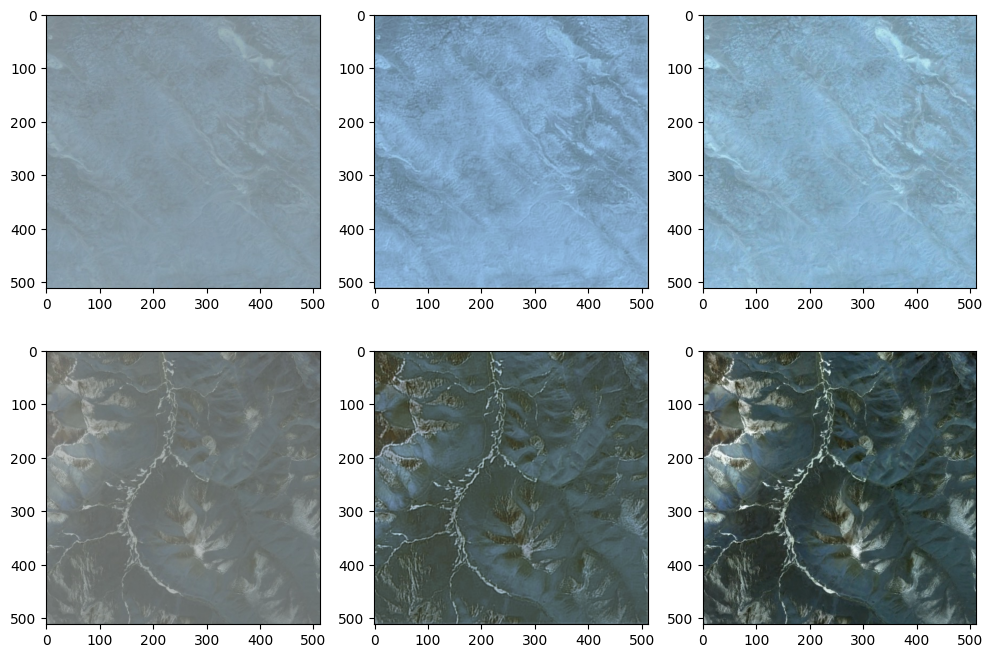

In [12]:
sample_image, sample_label = next(iter(train_dataloader))

output = model(sample_image.to(device))

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 8))

for i in range(2):
    axs[i][0].imshow(sample_image[i].permute(1,2,0))
    axs[i][1].imshow(output[i].permute(1,2,0).cpu().detach().numpy())
    axs[i][2].imshow(sample_label[i].permute(1,2,0))

plt.show()

In [14]:
output.shape

torch.Size([16, 3, 128, 128])